In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn
from math import sqrt 
from statsmodels.tsa.mar_model import MAR

import pylab
pylab.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Model Setup
order = 1
nstates = 2

switch_ar = False
switch_sd = False
switch_mean = True

In [5]:
# Load my dataset

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/'
file1 = 'Copy of PredictorData2014.xlsx'
file2 = 'measurestailrisk.xlsx'
file3 = 'VRPtable.txt'
tail_data = pd.read_excel(dir+file2,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
vol = pd.read_csv(dir+file3,delim_whitespace=True,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
pred = pd.read_excel(dir+file1,sheetname='Monthly',parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')

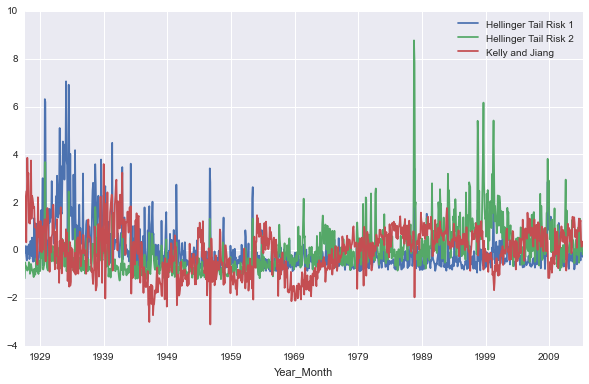

In [7]:
tail_data.plot()

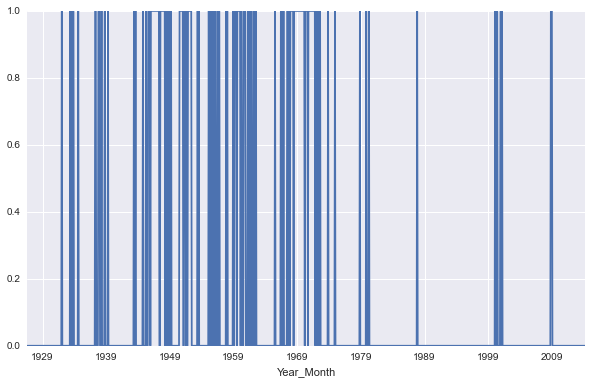

In [6]:
(tail_data['Kelly and Jiang'] < -1).plot()

In [9]:
######### My data
s_var = True
s_mean = True
mod = sm.tsa.MAR(tail_data['Kelly and Jiang'], order, nstates,switch_var=s_var,switch_mean=s_mean)

# Set the initial probability values
# see the file's docstring for more information
# In this case, we have the following transition matrix:
# | p_11 p_21 |
# | p_12 p_22 |
# where p_ij is the probability of transitioning from
# state i to state j
# Then the initial transition probabilities should be
# *the first row* of that matrix, i.e. it should be
# | p_11 p_21 |
init_trans_prob = np.r_[0.9, 0.1]
# so I am saying that p_11 = 0.75 and p_22 = 0.9
# i.e. there is a 75% probability of staying in state 1
# if you are already there and a 90% probability of staying
# in state 2 if you are already there.

# Set the full initial parameters array
initial_params = np.array(np.r_[
   np.log(init_trans_prob / (1 - init_trans_prob)),  # transition probabilities (transformed)
   0,  # AR parameters
   -np.log(0.8),-np.log(0.8),   # standard deviation (transformed)
   -0.2, 1.0   # Means
])

# Estimate the parameters via MLE
res = mod.fit(initial_params, method='bfgs');
params = res.params

# Transform the unconstrained parameters to interpretable parameters
final_params = params.copy()
final_params[0:2] = np.exp(final_params[0:2]) / (1 + np.exp(final_params[0:2])) # transition probabilities
final_params[3] = np.exp(-final_params[3]) # Standard deviation

Optimization terminated successfully.
         Current function value: 0.976982
         Iterations: 46
         Function evaluations: 60
         Gradient evaluations: 60


In [10]:
print('Parameter Estimates')
print('-------------------')
print('Transition probabilities:')
print(mod.transition_matrix(final_params[0:2]))
#print('AR Parameters (non-switching, here)')
#print(final_params[2:6])
print('Standard Deviation (non-switching, here)')
print(final_params[-4] * sqrt(12))
print(final_params[-3] * sqrt(12))
print('Means (switching)')
print('- in state 1:', final_params[-2])
print('- in state 2:', final_params[-1])

Parameter Estimates
-------------------
Transition probabilities:
[[ 0.98114223  0.00816906]
 [ 0.01885777  0.99183094]]
Standard Deviation (non-switching, here)
1.729186767
1.322863869
Means (switching)
('- in state 1:', -0.96508953482675353)
('- in state 2:', 0.41248836451585713)


In [11]:
# Filter the data
(
    marginal_densities, filtered_joint_probabilities,
    filtered_joint_probabilities_t1
) = mod.filter(params);

transitions = mod.separate_params(params)[0]

# Smooth the data
filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

# Save the data
tail_data['filtered'] = np.r_[
    [np.NaN]*order,
    filtered_marginal_probabilities[:,0]
]
tail_data['smoothed'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,0]
]

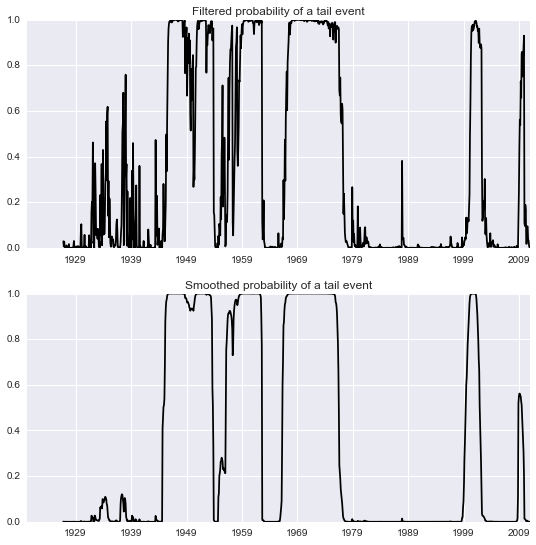

In [12]:
import matplotlib.pyplot as plt
from matplotlib import dates
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(211)
##ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(tail_data.index, tail_data.filtered, 'k')
ax.set(
    xlim=('1920-04-01', '2010-12-01'),
    ylim=(0,1),
    title='Filtered probability of a tail event'
);

ax = fig.add_subplot(212)
##ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(tail_data.index, tail_data.smoothed, 'k')
ax.set(
    xlim=('1920-04-01', '2010-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a tail event'
);